<img style="float: right;" src="Lorry_EP.png" alt="UoE" width="100px"/>
<img style="float: left;" src="UoE_Logo.png" alt="UoE" width="300px"/>

## Line source Modelling - an Introduction to RLine
<img style="float: right;" src="EnvPoll.png" alt="Environmental Pollution" width="60px"/></p>
## RLine - from US EPA
https://www.cmascenter.org/r-line/  
Jupyter notebook for ECSC09005 Environmental Pollution  
author: jbm *for* Session 2020-21  [version 0.13, latest 16:30, 27 Sep 2020]
## Background
RLine is an example of a soil-vegetation-atmosphere transport (SVAT) model and one we have used for many years in Land-Atmosphere Interactions. We normally use a version that runs on the University's servers - indeed if you look on Learn you'll see the practical schedule and worksheets we normally use. This year because of covid restrictions we have moved to a version that works via the web. SimSphere has been developed over 30 years in Professor Toby Carlson's group in the Meteorology Department at Penn State University and they recently released a FORTRAN version of the software which I've  packaged up into this Jupyter Notebook with routines written in python.  You can read all about SimSphere - its history, design and construction at Prof Carlson's web site - https://simsphere.ems.psu.edu/model.html  
<img style="float: right;" src="EP_Logo.png" alt="Env Poll" width="100px"/>
What I want you to get out of SimSphere is an appreciation for using simulation models to answer 'what if' questions of the kind we posed in week 1 of the course; if we replace forest with agriculture, what are the impacts on local or regional climate; if we plant trees which in turn reduce soil moisture locally, what impact might this have on boundary-layer development. Toby Carlson's group has a whole handbook posing similar questions which you can have a look at for your own ideas - the workbook is accessible from the 'File' menu above. The Workbook has some some great pointers to experiments you can run with SimSphere - it is nicely written in a conversational (and witty) style.

## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *json* to read data files in json format
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *subprocess* so we can run the model written in FORTRAN
- *ipywidgets* for interactivity
- *defins* for python code that just takes up space in the main notebook

In [4]:
#%matplotlib inline
import pandas as pd
import json
import csv
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import math
import sys
import tqdm as tqdm
import subprocess
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import HBox, Label

## Step 1: Get familiar with the model

In [5]:
# First time the model is run, bring in the default input data.
# Edit this file in your workspace - DO NOT edit the original file.

# Edit the parameter of interest and run the model. Repeat.

ret = subprocess.call(["./RLINEv1_2_gfortran_mac.exe"],shell=True)
print("Run complete")

Run complete


   Year  Julian_Day  Hour  X-Coordinate  Y-Coordinate  Z-Coordinate  \
0    12         264     1          10.0          10.0           1.5   
1    12         264     1          10.0          20.0           1.5   
2    12         264     1          10.0          30.0           1.5   
3    12         264     1          10.0          40.0           1.5   
4    12         264     1          10.0          50.0           1.5   

        C_G1       C_G2  Unnamed: 8  
0  2043070.0  2042370.0         NaN  
1  2043230.0  1824570.0         NaN  
2  2043180.0  1669700.0         NaN  
3  2043080.0  1544800.0         NaN  
4  2043160.0  1440970.0         NaN  
(196,) (196,) (196,)
100 196 196


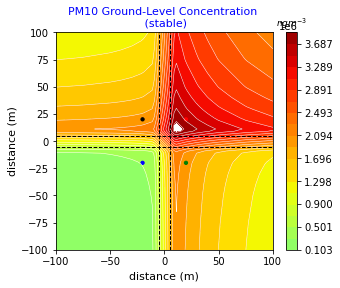

   Year  Month  Day  Jday  Hour   Hs    u*  w*  VPTG  CBL  ...  dir  zref  \
0    12      9   20   264     1  -10  0.10   0    99 -999  ...  225  11.4   
1    12      9   20   264     2    2  0.30   0    99 -999  ...  225  11.4   
2    12      9   20   264     3  150  0.25   0    99 -999  ...  225  11.4   
3    12      9   20   264     4   25  0.70   0    99 -999  ...  225  11.4   

       T  ztemp  s1  s2  s3  s4  s5  s6  
0  275.5    6.8  99  99  99  99  99  99  
1  278.0    6.8  99  99  99  99  99  99  
2  281.0    6.8  99  99  99  99  99  99  
3  278.0    6.8  99  99  99  99  99  99  

[4 rows x 26 columns]


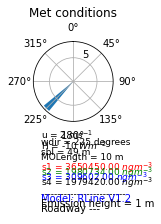

In [11]:
sites = []
max = min = 0
gs = gridspec.GridSpec(4, 4)
gs.update(left=0.10, right=0.95, hspace=0.05)
hourly_stab = ['stable','weakly stable','weakly convective','convective']


def plot_line_source(xx, yy, zz, hour):
    """Docstring"""
    # define grid
    xi = np.linspace(-100., 100., 100)
    yi = np.linspace(-100., 100., 100)
    print(xx.shape, yy.shape, zz.shape)
    print(len(xi), len(xx), len(zz))
    X,Y= np.meshgrid(xi,yi)
    #Z = griddata((x, y), z, (X, Y),method='nearest')
    zi = griddata((xx, yy), zz, (X, Y), method='linear')

    # plot the roadways running N-S and E-W
    ax1 = plt.subplot(gs[:, :-1])
    ax1.plot([5, 5], [-100, 100], color='k', linestyle='--', linewidth=1)
    ax1.plot([-5, -5], [-100, 100], color='k', linestyle='--', linewidth=1)
    ax1.plot([-100, 100], [-5, -5], color='k', linestyle='--', linewidth=1)
    ax1.plot([-100, 100], [5, 5], color='k', linestyle='--', linewidth=1)
    ax1.set_ylabel('distance (m)', fontsize=11)
    ax1.set_xlabel('distance (m)', fontsize=11)
    circ1 = plt.Circle((20, 20), 1.5, color='red')
    ax1.add_artist(circ1)
    circ2 = plt.Circle((20, -20), 1.5, color='green')
    ax1.add_artist(circ2)
    circ3 = plt.Circle((-20, -20), 1.5, color='blue')
    ax1.add_artist(circ3)
    circ4 = plt.Circle((-20, 20), 1.5, color='black')
    ax1.add_artist(circ4)

    # Contours etc explained here: 
    # http://matplotlib.org/examples/pylab_examples/contourf_demo.html
    levels = np.arange(min, max, (max-min)/20)
    # contour the gridded data, plotting dots at the nonuniform data points.
    ax1.contour(xi, yi, zi, levels, linewidths=0.5, colors='w')
    CS1 = ax1.contourf(xi, yi, zi, levels, cmap=plt.cm.jet, vmax=abs(zi).max(), vmin=-abs(zi).max())
    #ax1.contour(xi, yi, zi, levels, linewidths=0.5, colors='w')
    #CS1 = ax1.contourf(xi, yi, zi, levels, cmap = plt.cm.jet, vmax=abs(zi).max(), vmin=-abs(zi).max())
    # Make a colorbar for the ContourSet returned by the contourf call.
    cbar = plt.colorbar(CS1)  # orientation = 'horizontal')
    cbar.ax.set_title('$ng m^{-3}$',fontsize=9)

    ax1.set_xlim(-100, 100)
    ax1.set_ylim(-100, 100)
    ax1.set_title('PM10 Ground-Level Concentration \n (%s)'%hourly_stab[hour-1], fontsize=11, color='blue')
    plt.show()


def plot_met_data(datam, sites):
    """Docstring"""
    hour = datam['Hour']
    u = float(datam['u'])
    wdir = int(float(datam['dir']))
    MOLength = int(float(datam['L']))
    H = int(float(datam['Hs']))
    sbl = int(float(datam['SBL']))
    # print u,wdir,MOLength,H,sbl
    # convert wdir to radians
    wdirr = wdir * math.pi /180
    # Compute pie slices
    # from MatplotlIb web page of examples
    theta = wdirr
    radii = 8
    width = np.pi / 16
    # go clockwise as in a compass
    ax2 = plt.subplot(gs[:-1, -1], projection='polar')
    ax2.set_theta_direction(-1)
    # Make sure North points to top of page
    ax2.set_theta_offset(90*math.pi /180)
    ax2.bar(theta, radii, width=width, bottom=0.0)
    ax2.set_title('Met conditions')
    ax3 = plt.subplot(gs[-1, -1])
    ax3.set_frame_on(False)
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax3.text(0.1, 1.5, r'u = %d $m s^{-1}$'%u, fontsize=9)
    ax3.text(0.1, 1.4, r'wdir = %i degrees'%wdir, fontsize=9)
    ax3.text(0.1, 1.3, r'H = %d $Wm^{-2}$'%H, fontsize=9)
    ax3.text(0.1, 1.2, r'sbl = %d m'%sbl, fontsize=9)
    ax3.text(0.1, 1.1, r'MOLength = %d m'%MOLength, fontsize=9)
    ax3.text(0.1, 1.0, r' ', fontsize=10)
    # format returns a str
    ax3.text(0.1, 0.9, r's1 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[0]), fontsize=9,color='red')
    ax3.text(0.1, 0.8, r's2 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[1]), fontsize=9,color='green')
    ax3.text(0.1, 0.7, r's3 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[2]), fontsize=9,color='blue')
    ax3.text(0.1, 0.6, r's4 = %s $ng m^{-3}$' % '{0:.2f}'.format(sites[3]), fontsize=9,color='black')
    ax3.text(0.1, 0.5, r' ', fontsize=10)
    ax3.text(0.1, 0.4, r'-------------------------- ', fontsize=9)
    ax3.text(0.1, 0.3, r'Model: RLine V1.2', fontsize=10,color='blue')
    ax3.text(0.1, 0.2, r'Emission height = 1 m', fontsize=10)
    ax3.text(0.1, 0.1, r'Roadway ---', fontsize=10)

    fig = plt.gcf()
    fig.facecolor='white'
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    # fig.set_size_inches(10, 8)
    fig.subplots_adjust(top=0.85, left=0.1, right=0.95, bottom=0.1)
    fig.savefig('rline_%d.png'%hour, dpi=100)

    plt.show()


def find_maxmin():
    """Docstring"""
    max = min = 0.0
    for row in data:
        temp = float(row[' C_G1'])/1e3 + float(row[' C_G2'])/1e3  # ng m-3
        if row == 1:
            min = temp
        if temp > max:
            max = temp
        if temp < min:
            min = temp
    return max, min


def get_platform():
    """Docstring"""
    platforms = {
        'linux1' : 'Linux',
        'linux2' : 'Linux',
        'darwin' : 'OS X',
        'win32' : 'Windows'
    }
    if sys.platform not in platforms:
        return sys.platform
    
    return platforms[sys.platform]

# ----------------------------------------------------------------------


# which OS is this running on?
platform = get_platform()
"""
Read the csv file
"""
# inpath = '/Users/jbm/Documents/python/RLine/'
inpath = ""
infilename = 'Output_Example_Numerical_09-12.csv'
infilename2 = 'Met_Example.csv'   
# use Pandas to read in emissions data
dfe=pd.read_csv("Output_Example_Numerical_09-12.csv", header=10, skipinitialspace=True)
# Split into hourly dataframes for graphing
# https://stackoverflow.com/questions/54046707/pandas-split-one-dataframe-into-multiple-dataframes
for h in dfe['Hour'].unique():
    temp = 'dfe_{}'.format(h)    
    vars()[temp] = dfe[dfe['Hour']==h]
print(dfe_1.head(5))
    
# extract the x, y, z-values to 1-D arrays for plotting
xx = dfe_1['X-Coordinate'].to_numpy()
yy = dfe_1['Y-Coordinate'].to_numpy()
zz = (dfe_1['C_G1']+dfe_1['C_G2']).to_numpy()
    
max = (dfe_1['C_G1']+dfe_1['C_G2']).max()
min = (dfe_1['C_G1']+dfe_1['C_G2']).min()
#print(min,max)
# get the concentration values at the 4 receptor sites
dfs1 = dfe_1[((dfe_1['X-Coordinate'] == 20.000) & (dfe_1['Y-Coordinate'] == 20.000))]
dfs2 = dfe_1[((dfe_1['X-Coordinate'] == 20.000) & (dfe_1['Y-Coordinate'] == -20.000))]
dfs3 = dfe_1[((dfe_1['X-Coordinate'] == -20.000) & (dfe_1['Y-Coordinate'] == -20.000))]
dfs4 = dfe_1[((dfe_1['X-Coordinate'] == -20.000) & (dfe_1['Y-Coordinate'] == 20.000))]
#print(dfs1)
s1z = dfs1.iloc[0]['C_G1']+dfs1.iloc[0]['C_G2']
s2z = dfs2.iloc[0]['C_G1']+dfs2.iloc[0]['C_G2']
s3z = dfs3.iloc[0]['C_G1']+dfs3.iloc[0]['C_G2']
s4z = dfs4.iloc[0]['C_G1']+dfs4.iloc[0]['C_G2']
    
#print(s1z)
sites = [s1z, s2z, s3z, s4z]
# pass to plotting routine
plot_line_source(xx, yy, zz, 1)
    
# use Pandas to read in meteorology data
dfm=pd.read_csv("Met_Example.csv", skip_blank_lines=True, skipinitialspace=True)
print(dfm.head(4))
for h in dfm['Hour'].unique():
    temp = 'dfm_{}'.format(h)    
    vars()[temp] = dfm[dfm['Hour']==h]
plot_met_data(dfm_1, sites)
#----------------------------------------------------------------------

In [12]:
# which OS is this running on?
platform = get_platform()
# use Pandas to read in emissions data
dfe=pd.read_csv("Output_Example_Numerical_09-12.csv", header=10, skipinitialspace=True)

# lets have a look at the first 5 rows of data
dfe.head(5)
#extract_hourly_data(dfe,1)

,Year,Julian_Day,Hour,X-Coordinate,Y-Coordinate,Z-Coordinate,C_G1,C_G2,Unnamed: 8
0,12,264,1,10.0,10.0,1.5,2043070.0,2042370.0,NaN
1,12,264,1,10.0,20.0,1.5,2043230.0,1824570.0,NaN
2,12,264,1,10.0,30.0,1.5,2043180.0,1669700.0,NaN
3,12,264,1,10.0,40.0,1.5,2043080.0,1544800.0,NaN
4,12,264,1,10.0,50.0,1.5,2043160.0,1440970.0,NaN


In [13]:
# use Pandas to read in meteorology data
dfm=pd.read_csv("Met_Example.csv", skip_blank_lines=True, skipinitialspace=True)
#dfm.set_index('Year')
# lets have a look at the first 5 rows of data
dfm.head(5)

,Year,Month,Day,Jday,Hour,Hs,u*,w*,VPTG,CBL,...,dir,zref,T,ztemp,s1,s2,s3,s4,s5,s6
0,12,9,20,264,1,-10,0.10,0,99,-999,...,225,11.4,275.5,6.8,99,99,99,99,99,99
1,12,9,20,264,2,2,0.30,0,99,-999,...,225,11.4,278.0,6.8,99,99,99,99,99,99
2,12,9,20,264,3,150,0.25,0,99,-999,...,225,11.4,281.0,6.8,99,99,99,99,99,99
3,12,9,20,264,4,25,0.70,0,99,-999,...,225,11.4,278.0,6.8,99,99,99,99,99,99


In [14]:
# Find max,min so we can set appropriate contour intervals
max = dfe['C_G1'].max()
min = dfe['C_G1'].min()
print(min,max) 
#print(datam)    
#extract_hourly_data()

3277.94 2043240.0


# END